# AI-CA6
## Custring
## Arian Firoozi - 810100196

In this project the goal is to use clustring to cluster and predict data topics from persian news website 'asriran.com'. For clustring, sklearn Kmeans and DBSCAN models are used as well as gensim Word2Vec model to vectorize the data. Preprocessing is done with parsivar library normalizer, stemmer and tokenizer.

1. Most models are designed by assuming that data classes are balanced in the first place. Using imbalanced train or test data results in incorrect assumption about model accuracy and efficiency. Assuming most of the train data consists of class A, a model that predict most of the results to be in that class would score high on accuracy but it is not possible to say if the model actually works fine or it just predicts the outcome as class A. On the other hand training will take longer time for specific classes, lowering the efficiency of the model and possibely overtraining on certain classes and undertraining for others. 

## Phase 1: PreProcess

There ar many preprocess methods to use other than what is implemented here. To name a few, spellcheck could be used but i didn prefer to not implement it due to low speed and since the dataset is written in good spelling, it wouldn't be useful. Another method to use is categorizing words based on which part of sentence they are in before training the model.

2. Stemming refers to the act of chopping the prefixes and suffixes of a word in order to get a more general word that can be processed more easily. Lemmatization is converting the word to it's base for same purpose. For example it is obvious that the words 'eat', 'eating, 'eats' and 'ate' are similiar to each other, and if we conver all of this words to 'eat', model will understand that all of them refer to a the same concept. Both techniques are great ways to reduce complexity of the model and since lemmatization is more general, I implemented that in the preprocess phase.

In [813]:
import numpy as np
import pandas as pd

ADDR = "train.csv"
TEST_ADDR = "test.csv"
CLUSTERS = 6
SW_URL = 'https://github.com/ziaa/Persian-stopwords-collection/blob/master/Stopwords/Savoy/persianST.txt'


In [814]:
import requests

req = requests.get(SW_URL)
stopwords_json = req.json()

stop_words = stopwords_json['payload']['blob']['rawLines']
len(stop_words)


332

In [815]:
import tqdm
from parsivar import Normalizer
from parsivar import stemmer
from parsivar import Tokenizer
pnormalizer = Normalizer(statistical_space_correction=True)
ptokenizer = Tokenizer()
pstemmer = stemmer.FindStems()

class Preprocess:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def normalize(self):
        self.dataset['content'] = self.dataset.apply(lambda text: pnormalizer.normalize(doc_string=text['content']), axis=1)

    def tokenize(self):
        self.dataset['content'] = self.dataset.apply(lambda text: ptokenizer.tokenize_words(doc_string=text['content']), axis=1)

    def rm_stopwords(self):
        for i, line in enumerate(self.dataset['content']):
            new_line = []
            for word in line:
                if word not in stop_words:
                    new_line.append(word)
                    
            self.dataset['content'][i] = new_line

    def stem(self):
        self.dataset['content'] = self.dataset.apply(lambda text: [pstemmer.convert_to_stem(word) for word in text['content']], axis=1)

    def rm_smallwords(self, size=3):
        work_done = 1
        while (work_done):
            work_done = 0
            for (i, txt) in enumerate(self.dataset['content']):
                for word in txt:
                    if (len(word) < size):
                        work_done=1
                        self.dataset['content'][i].remove(word)

    def preprocess(self):
        self.normalize()
        self.tokenize()
        self.rm_stopwords()
        self.stem()
        self.rm_smallwords()
        

In [816]:
train_data_raw = pd.read_csv(ADDR)
display(train_data_raw)
train_data = Preprocess(train_data_raw)
train_data.preprocess()

display(train_data.dataset)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


,label,content
0,فناوری,"[گزارش, منتشر, حاکی, کاربر, تلگرام, مناطقی, جه..."
1,ورزشی,"[سوپر‌استار, سینما, قهرمان, ووشو‌کونگ‌فو, حضور..."
2,حوادث,"[مدیرعامل, شرکت, عمران, کیش, فوت, نفر, آتش‌سوز..."
3,فناوری,"[نوجوان, انگلیسی, اتهام, هک‌حساب‌های, کاربری‌ا..."
4,سلامت,"[دانشمند, جدید, مطالعات, اثرات, جدید, ویروس, ک..."
...,...,...
8995,حوادث,"[شانزدهم, مهر, درپی, تماس, مرکز, فوریت, پلیسی,..."
8996,ورزشی,"[اتحادیه, فوتبال, ترینیداد, توباگو, اعلام, کرد..."
8997,فرهنگی/هنری,"[اسم, فیلم, بخش, مسابقه, مستند, ششمین, دوره, ج..."
8998,حوادث,"[کامیونت, حامل, تخته, چوبی, عصر, دیروز, چهارشن..."


## Phase 2: Models

3. Clustring methods classify the information based on distances of data. To define this distances, we need to convert any data that is going to be classified into numeric values. This numeric values describe the features of a dataset in form of vectors that the model is going to cluster.

4. Word2Vec model finds similarity between words and classes and clusters the data, were Doc2Vec takes tagged documents as input and clusters those based on similarity between words used in each document. Both methods are implemented below and since word2vec had significiantly higher accuracy on this particular dataset, I prefered to continue the project with that one.

In [817]:
from gensim.models.doc2vec import TaggedDocument

tagged_data = []

for (i, txt) in tqdm.tqdm(enumerate(train_data.dataset['content'])):
    tagged_data.append(TaggedDocument(txt,train_data.dataset['label'][i]))

tagged_data

9000it [00:00, 132723.21it/s]


[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'مواجه', 'شد&شو', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایقی', 'پیام\u200cرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'کرد', 'دسترسی', 'کاربر', 'این', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'مواجه', 'طبق', 'این', 'پیام', 'نظر', 'رسید&رس', 'منشا', 'این', 'اختلالات', 'ظهر', 'پنج\u200cشنبه', 'خارجی', 'سوی', 'این', 'پیام\u200cرسان', 'ارتباطی', 'داخل', 'کشور', 'این', 'پیام\u200cرسان', 'این', 'خصوص', 'عنوان', 'کرده', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'چنین', 'اختلال', 'شد&شو', 'حال', 'بررسی', 'برطرف', 'کردن', 'مشکل', 'مربوطه', 'امید', 'به\u200cزودی', 'این', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یافت&یاب'], tags='فناوری'),
 TaggedDocument(words=['سوپر\u200cاستار', 'سینما', 'قهرمان', 'ووشو\u200cکونگ\u200cفو', 'حضور', 'شهر', 'شانه', 'نزدیک', 'مسابقات', 'ووشوی', 'قهرمانی', 'جهان', 'شاهد', 'گزارش', 'رابطه', 'عمومی', 'فدراسیون', 'ووشو', 'آنتونی\u200cگ

In [818]:
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec

model = Word2Vec(sentences=train_data.dataset['content'], vector_size=300, sg=1, seed=196)

In [819]:
model.wv.most_similar('فوتبال')

[('باشگاهی', 0.6975752711296082),
 ('فوتسال', 0.673553466796875),
 ('والیبال', 0.6688145995140076),
 ('ترینیداد', 0.6505388617515564),
 ('توباگو', 0.6422743201255798),
 ('اسکوچیچ', 0.6410093903541565),
 ('هندبال', 0.6392202377319336),
 ('کی\u200cروش', 0.6369712352752686),
 ('AFC', 0.636719286441803),
 ('فدارسیون', 0.6317893862724304)]

In [820]:
doc_model = Doc2Vec(vector_size=30, epochs=50, seed=196)
doc_model.build_vocab(tagged_data)
doc_model.train(tagged_data, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

In [821]:
doc_model.wv.most_similar('فوتبال')

[('باشگاهی', 0.7071536779403687),
 ('لیگ', 0.663390040397644),
 ('فوتسال', 0.6440176367759705),
 ('قهرمانی', 0.6330591440200806),
 ('والیبال', 0.6308963894844055),
 ('ضرغامی', 0.6102630496025085),
 ('سینما', 0.6061661243438721),
 ('کارفرما', 0.6050159335136414),
 ('کتابخوانی', 0.5974944233894348),
 ('هاست', 0.5942808389663696)]

In [822]:
def vectorize(dataset, model):
    features = []
    for news in dataset:
        vectors = []
        for word in news:
            if word in model.wv:
                try: vectors.append(model.wv[word])
                except: continue

        if len(vectors):
            features.append(np.array(vectors).mean(axis=0))
        else:
            features.append(np.zeros(model.vector_size))

    return features

vectorized_data = vectorize(train_data.dataset['content'].values, model)

from sklearn.preprocessing import StandardScaler
vectorized_data = StandardScaler().fit_transform(vectorized_data)

In [823]:
vectorized_data_doc = [doc_model.infer_vector(sentence.words) for sentence in tagged_data]

5. K-means: this method is centroid-based, meaning that we seperate the data to k clusters and each cluster is reperesented by it's center (which is considered the mean of vectors in the cluster). K-means is sensetive to outlier data and model works better in well seperate data. Number of clusters is an importent factor to consider since the model requiers the user to define number of clusters. We have 6 class of news in the training data so number of clusters must be 6 as well. 

    DBSCAN: DBSCAN is a density-based method. It puts data vectors close together in the same cluster. Since it can identify closeness of vectors, we don't need to give a fixed number of clusters and it can tolerate the outlier data.

### K-means

In [824]:
from sklearn.cluster import KMeans
km_train_clusters = KMeans(n_clusters=CLUSTERS).fit(X=vectorized_data, y=train_data.dataset['label'])

c:\Users\arian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [825]:
def get_label_to_id(true_labels, cluster_labels):
    km_cluster_labels = {}
    for i, label in enumerate(true_labels):
        if label in km_cluster_labels.keys():
            km_cluster_labels[label].append(cluster_labels[i])
        else:
            km_cluster_labels[label] = [cluster_labels[i]]
        
    for label in km_cluster_labels:
        label_freq = np.zeros(CLUSTERS)

        for i in km_cluster_labels[label]:
            label_freq[i] += 1

        print(label, np.argmax(label_freq), km_cluster_labels[label].count(np.argmax(label_freq))/ len(km_cluster_labels[label]))
        km_cluster_labels[label] = np.argmax(label_freq)

    return km_cluster_labels

def get_id_to_label(cluster_labels):
    id_to_label = {}
    for label in np.array([i for i in cluster_labels.keys()]):
        id_to_label[cluster_labels[label]] = label
    return id_to_label

km_cluster_labels = get_label_to_id(train_data.dataset['label'],km_train_clusters.labels_)
id_to_label = get_id_to_label(km_cluster_labels)

فناوری 1 0.9146666666666666
ورزشی 4 0.906
حوادث 0 0.9086666666666666
سلامت 2 0.8633333333333333
سیاسی 5 0.9606666666666667
فرهنگی/هنری 3 0.706


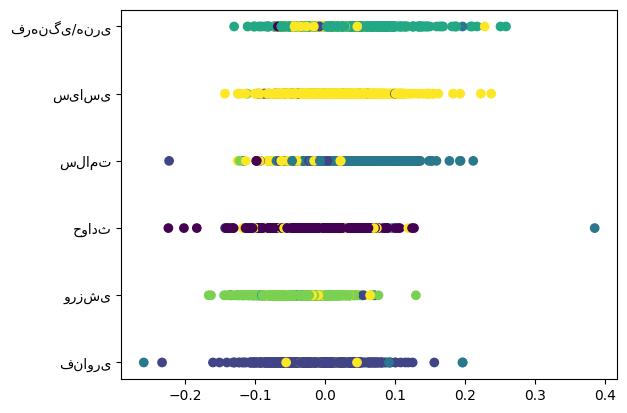

In [826]:
import matplotlib.pyplot as plt
x= np.array([l.mean() for l in vectorized_data])
plt.scatter(x=x, y=train_data.dataset['label'],c=km_train_clusters.labels_)

In [827]:
test_data_raw = pd.read_csv(TEST_ADDR)

test_data = Preprocess(test_data_raw)
test_data.preprocess()

In [828]:
vectorized_train_doc = [doc_model.infer_vector(sentence) for sentence in test_data.dataset['content']]

In [829]:
km_test_vecs = vectorize(test_data.dataset['content'].values, model)
km_test_vecs = StandardScaler().fit_transform(km_test_vecs)
km_preds = km_train_clusters.predict(X=km_test_vecs)

In [844]:
true = 0
for i, cluster_id in enumerate(km_preds):
    if id_to_label[cluster_id] == test_data.dataset['label'][i]:
        true+=1

km_accuracy = true/len(km_preds)
km_accuracy


0.8816143497757848

### DBSCAN

In [831]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

vectors = StandardScaler().fit_transform(vectorized_data_doc)

db_train_clusters = DBSCAN(eps=0.35, min_samples=150, metric='cosine').fit(X=vectors, y=[sentence.tags for sentence in tagged_data])

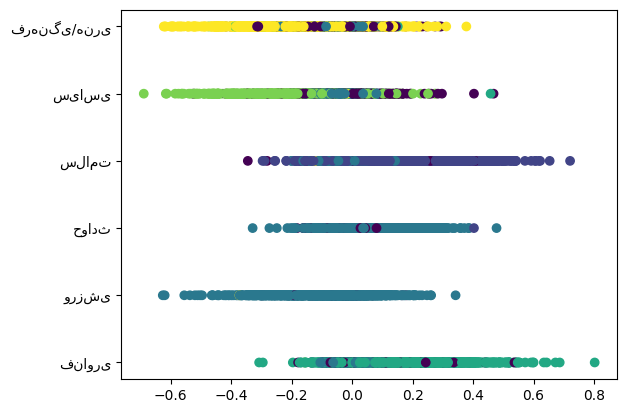

In [832]:
import matplotlib.pyplot as plt
x= np.array([l.mean() for l in vectors])
plt.scatter(x=x, y=train_data.dataset['label'],c=db_train_clusters.labels_)

In [853]:
def get_label_to_id(true_labels, cluster_labels):
    db_cluster_labels = {}
    for i, label in enumerate(true_labels):
        if label in db_cluster_labels.keys():
            db_cluster_labels[label].append(cluster_labels[i])
        else:
            db_cluster_labels[label] = [cluster_labels[i]]
        
    for label in db_cluster_labels:
        label_freq = np.zeros(CLUSTERS)

        for i in db_cluster_labels[label]:
            label_freq[i] += 1

        print(label, np.argmax(label_freq), db_cluster_labels[label].count(np.argmax(label_freq))/ len(db_cluster_labels[label]))
        db_cluster_labels[label] = np.argmax(label_freq)

    return db_cluster_labels

def get_id_to_label(cluster_labels):
    id_to_label = {}
    for label in np.array([i for i in cluster_labels.keys()]):
        id_to_label[cluster_labels[label]] = label
    return id_to_label

db_cluster_labels = get_label_to_id(train_data.dataset['label'],db_train_clusters.labels_)
db_id_to_label = get_id_to_label(db_cluster_labels)

فناوری 2 0.7846666666666666
ورزشی 1 0.982
حوادث 1 0.9013333333333333
سلامت 0 0.7966666666666666
سیاسی 3 0.5266666666666666
فرهنگی/هنری 4 0.6713333333333333


In [834]:
import scipy as sp

def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    for j, x_new in enumerate(X_new):
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

In [835]:

test_data_raw = pd.read_csv(TEST_ADDR)

test_data = Preprocess(test_data_raw)
test_data.preprocess()

In [836]:
db_test_vecs = [doc_model.infer_vector(sentence) for sentence in test_data.dataset['content']]

db_test_vecs = StandardScaler().fit_transform(db_test_vecs)

In [837]:
db_preds = dbscan_predict(db_train_clusters, db_test_vecs)

In [845]:
true = 0
for i, cluster_id in enumerate(db_preds):
    if cluster_id != -1 and db_id_to_label[cluster_id] == test_data.dataset['label'][i]:
        true+=1

db_accuracy = true/len(db_preds)
db_accuracy

0.5390134529147982

6. Outputs of both models have been shown above. DBScan has lower accuracy, which shows that our initial data is not dense and data points' density is not evenly distributed. This accuracy diffenrence could also be a optimization problem since non of the model parameters are optimized using any tools.

## Phase 3: Dimension Reduction

7. PCA is one of the most commonley used methods to reduce the amount of features in vectors. In this example, feature vector size is set to 300 so each word has a vector of size 300. To plot this, we must reduce the size to 2. PCA finds the principal components that "explains the greatest amount of variance" between the featurs; meaning that each new dimension describes the most amount of information possible. PCA does that by making a covariance matrix from original features and finding eigenvalues of that matrix. Eigenvectors are then ranked by the variance and top vectors are set as new feature vectors.

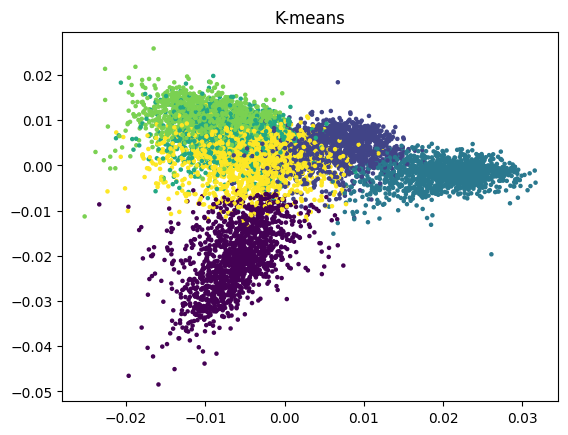

In [846]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

vec_trans = np.array(vectorized_data).transpose()
pca.fit(vec_trans)

import matplotlib.pyplot as plt

x= np.array([l.mean() for l in vectorized_data])
plt.scatter(x=pca.components_[0], y=pca.components_[1], c=km_train_clusters.labels_, s=[5 for _ in range(len(pca.components_[0]))])
plt.title('K-means')
plt.show()

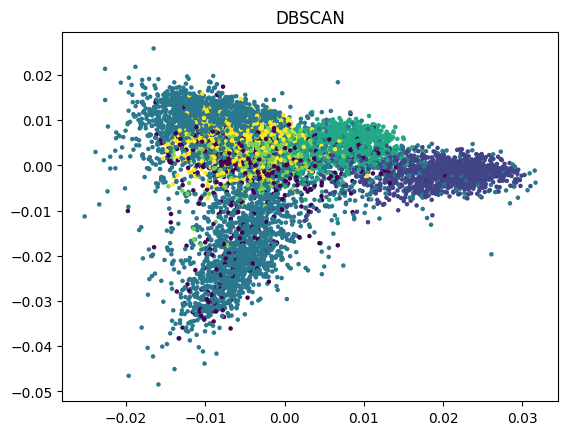

In [847]:
pca = PCA(n_components=2)

vec_trans = np.array(vectorized_data).transpose()
pca.fit(vec_trans)

import matplotlib.pyplot as plt

x= np.array([l.mean() for l in vectorized_data])
plt.scatter(x=pca.components_[0], y=pca.components_[1], c=db_train_clusters.labels_, s=[5 for _ in range(len(pca.components_[0]))])
plt.title('DBSCAN')
plt.show()

## Analysing the Outcome

8.  
    Homogenety shows how accurate is a cluster in containing objects only in it's own class. It    can be calculated by evaluating means of entropies in each cluster.

    Sillhoutte score shows the similarity between objects in a cluster to eachother compared to objects in other clusters. This measure can be calculated by the formula below:

    $$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

    where b(i) and a(i) are sum of the distances of the vector i from all vectors from it's own and it's nearest clusters.
    
9. scores are calculated below.

In [848]:
from sklearn.metrics import homogeneity_score, silhouette_score

print("Silhouette score for km model:", silhouette_score(km_test_vecs, km_preds))
print("Homogenity score for km model:", homogeneity_score(test_data.dataset['label'], [id_to_label[id] for id in km_preds]))

Silhouette score for km model: 0.17720071484974048
Homogenity score for km model: 0.7439059847814999


In [855]:
from sklearn.metrics import homogeneity_score
db_id_to_label[-1]='noise'
 
print("Silhouette score for db model:", silhouette_score(db_test_vecs, db_preds))
print("Homogenity score for db model:", homogeneity_score(test_data.dataset['label'], [db_id_to_label[id] for id in db_preds]))

Silhouette score for db model: 0.0700885400484046
Homogenity score for db model: 0.476544297466626


10. Model parameters can be optimized by algorithms like OPTICS, we can preprocess data and make clusters more dense (methods are discussed in preprocess part). We can also extract more features for text data. One of the reasons that DBScan model is not working well is that it only extracts 30 features for time optimization and it is probably not enough to cluster accuratly.